# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [4]:
X_train = pd.read_csv('HAPT_Dataset/X_train_ready.csv')
X_test = pd.read_csv('HAPT_Dataset/X_test_ready.csv')

X_train.shape, X_test.shape

((7767, 547), (3162, 547))

In [3]:
y_train = pd.read_csv('HAPT_Dataset/Train/y_train.txt', index_col=False, header=None)
y_test = pd.read_csv('HAPT_Dataset/Test/y_test.txt', index_col=False, header=None)

y_train.shape, y_test.shape

((7767, 1), (3162, 1))

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [5]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)

Train: (4368, 547) (4368, 1)
Valid: (1457, 547) (1457, 1)


### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [26]:
clf = DecisionTreeClassifier(random_state=2360873, max_depth=4).fit(X_train, y_train)

dic = {'score':clf.feature_importances_,'features':X_train.columns}
print('Variáveis com mais importância:')
df = pd.DataFrame(dic).sort_values('score',ascending=False).reset_index(drop=True).head(3)
df

Variáveis com mais importância:


,score,features
0,0.292704,tGravityAcc-Max-1
1,0.252060,fBodyAcc-BandsEnergyOld-13
2,0.169823,tGravityAcc-Max-2


In [29]:
mais_importantes = df.features.values

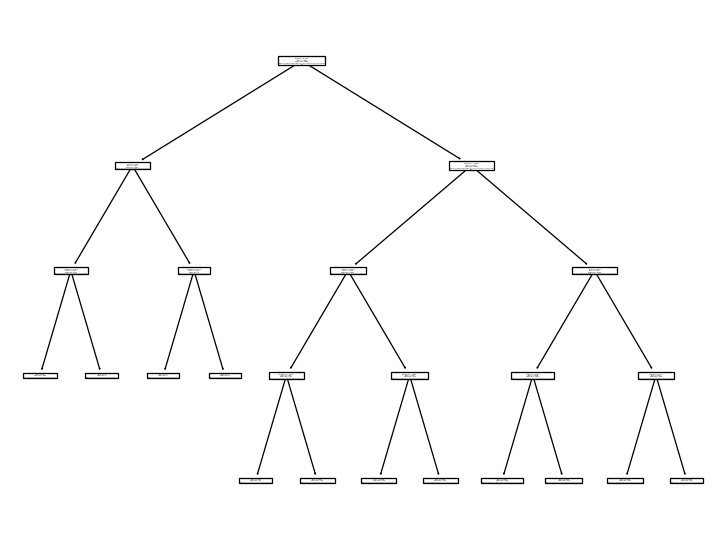

In [18]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(8,6),dpi=92)
#criando o plot
plot_tree(clf,ax=ax)
#plotando o gráfico
plt.tight_layout();

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [32]:
%%time
X_train = X_train[mais_importantes]
X_test = X_test[mais_importantes]
X_valid = X_valid[mais_importantes]

caminho = DecisionTreeClassifier(random_state=2360873, max_depth=4).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha, max_depth=4).fit(X_train, y_train)
    clfs.append(clf)
    
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 76.25
CPU times: total: 125 ms
Wall time: 151 ms


DecisionTreeClassifier(ccp_alpha=0.007776055397353189, max_depth=4,
                       random_state=2360873)

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

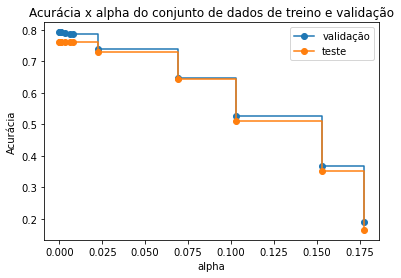

In [33]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

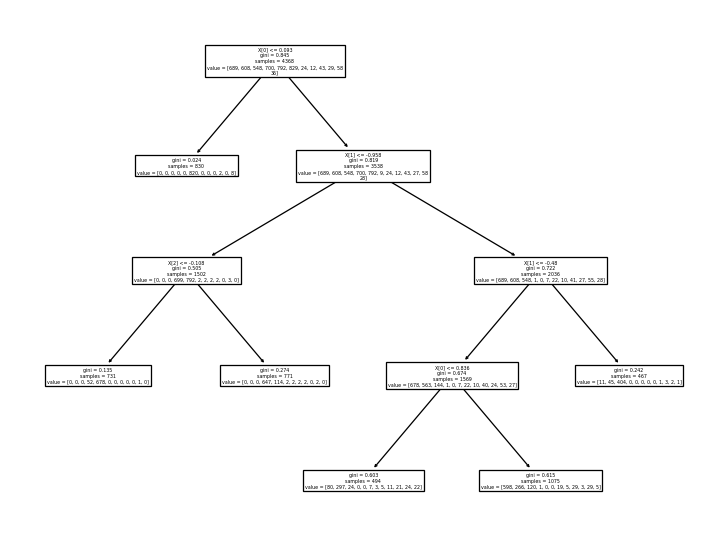

In [37]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(8,6),dpi=92)
#criando o plot
plot_tree(melhor_arvore,ax=ax)
#plotando o gráfico
plt.tight_layout();

Acurácia: 70.62


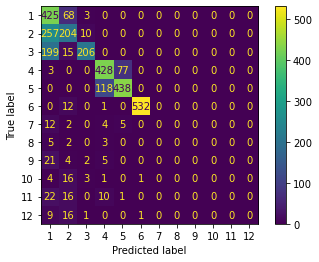

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

acuracia_teste = melhor_arvore.score(X_test, y_test)

print(f'Acurácia: {acuracia_teste*100:.2f}')
ConfusionMatrixDisplay.from_estimator(melhor_arvore, X_test, y_test);